# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

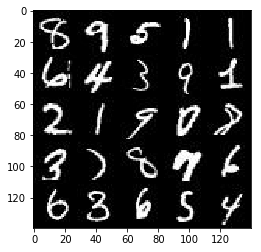

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

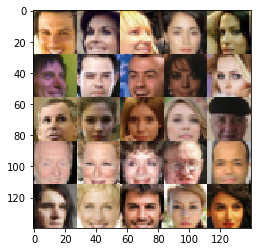

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    # Don't use the same name for a tf placeholder and a variable. It'll create error. 
    learning_rate = tf.placeholder(tf.float32, (None), name='learn_rate')
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/joe/anaconda3/envs/tf_1_2/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/joe/anaconda3/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
        
        x1 = tf.image.resize_images(images, [32, 32])
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.7)
        # 16 * 16 * 64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.7)        
        # 8 * 8 * 128
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same',
                             kernel_initializer=tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.7)
        # 4 * 4 * 256
        
        # Flatten and apply sigmoid
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    
    reuse = False if is_train else True
    
    with tf.variable_scope("generator", reuse=reuse):
        
        # Begin with a fully connected layer
        x1 = tf.layers.dense(z, 4 * 4 * 512, kernel_initializer=tf.contrib.layers.xavier_initializer())
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        #x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob=0.7)
        
        # First conv layer, after which shape becomes 8 * 8 * 256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob=0.7)
        
        # Second conv layer, after which shape becomes 16 * 16 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob=0.7)
        
        # Third conv layer, after which shape becomes 32 * 32 * 64
        x4 = tf.layers.conv2d_transpose(x3, 64, 5, strides=2, padding='same', 
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(alpha * x4, x4)
        x4 = tf.nn.dropout(x4, keep_prob=0.7)
        
        # Output layer. shape is 32 * 32 * 3
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=2, padding='same',
                                           kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        
        # Resize and apply tanh
        logits = tf.image.resize_images(logits, [28,28])
        out = tf.tanh(logits)        
        
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    print_every = 10
    show_every = 100
    
    tf.reset_default_graph()
        
    input_real, input_z, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])

    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)


    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(128, z_dim))

    samples, losses = [], []
    steps = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images *= 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate:learning_rate})

                if steps % print_every == 0:
                    
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    
                    samples.append(gen_samples)
                    _ = show_generator_output(sess, 9, input_z, data_shape[3], data_image_mode)
                    pyplot.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 3.7218
Epoch 1/2... Discriminator Loss: 0.7277... Generator Loss: 2.5697
Epoch 1/2... Discriminator Loss: 0.9861... Generator Loss: 2.1039
Epoch 1/2... Discriminator Loss: 1.3928... Generator Loss: 1.1112
Epoch 1/2... Discriminator Loss: 0.7937... Generator Loss: 3.2412
Epoch 1/2... Discriminator Loss: 1.0299... Generator Loss: 1.7166
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 1.3215
Epoch 1/2... Discriminator Loss: 0.9022... Generator Loss: 2.7074
Epoch 1/2... Discriminator Loss: 0.6853... Generator Loss: 3.5821
Epoch 1/2... Discriminator Loss: 0.8891... Generator Loss: 2.9170


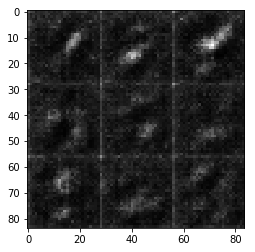

Epoch 1/2... Discriminator Loss: 1.1497... Generator Loss: 1.2434
Epoch 1/2... Discriminator Loss: 1.0481... Generator Loss: 3.2479
Epoch 1/2... Discriminator Loss: 0.9992... Generator Loss: 3.0394
Epoch 1/2... Discriminator Loss: 0.9638... Generator Loss: 2.3855
Epoch 1/2... Discriminator Loss: 1.0982... Generator Loss: 2.5634
Epoch 1/2... Discriminator Loss: 1.5918... Generator Loss: 2.6786
Epoch 1/2... Discriminator Loss: 1.2809... Generator Loss: 2.0170
Epoch 1/2... Discriminator Loss: 1.0557... Generator Loss: 1.2032
Epoch 1/2... Discriminator Loss: 1.0345... Generator Loss: 1.2719
Epoch 1/2... Discriminator Loss: 0.9064... Generator Loss: 2.0572


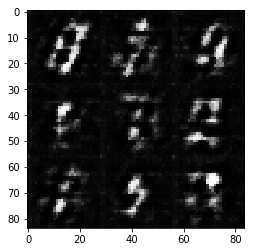

Epoch 1/2... Discriminator Loss: 1.2484... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.1051... Generator Loss: 1.4530
Epoch 1/2... Discriminator Loss: 1.0459... Generator Loss: 1.7930
Epoch 1/2... Discriminator Loss: 1.0021... Generator Loss: 1.1989
Epoch 1/2... Discriminator Loss: 1.4301... Generator Loss: 1.2373
Epoch 1/2... Discriminator Loss: 1.4121... Generator Loss: 0.8287
Epoch 1/2... Discriminator Loss: 1.1832... Generator Loss: 1.3640
Epoch 1/2... Discriminator Loss: 1.2660... Generator Loss: 1.0000
Epoch 1/2... Discriminator Loss: 1.1769... Generator Loss: 1.1118
Epoch 1/2... Discriminator Loss: 0.9477... Generator Loss: 2.0366


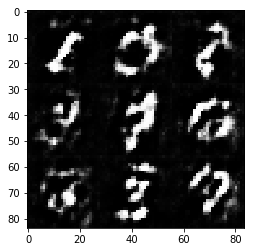

Epoch 1/2... Discriminator Loss: 1.0352... Generator Loss: 1.3567
Epoch 1/2... Discriminator Loss: 0.8425... Generator Loss: 1.7424
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.0938... Generator Loss: 1.1377
Epoch 1/2... Discriminator Loss: 1.1934... Generator Loss: 1.1747
Epoch 1/2... Discriminator Loss: 0.9125... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.2974... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 0.9280
Epoch 1/2... Discriminator Loss: 1.0565... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 0.9907... Generator Loss: 1.7574


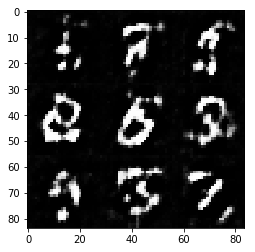

Epoch 1/2... Discriminator Loss: 0.9382... Generator Loss: 1.6255
Epoch 1/2... Discriminator Loss: 1.0061... Generator Loss: 2.1226
Epoch 1/2... Discriminator Loss: 1.0125... Generator Loss: 1.9608
Epoch 1/2... Discriminator Loss: 1.1659... Generator Loss: 3.0514
Epoch 1/2... Discriminator Loss: 1.4783... Generator Loss: 0.7900
Epoch 1/2... Discriminator Loss: 0.9870... Generator Loss: 1.2238
Epoch 1/2... Discriminator Loss: 0.9894... Generator Loss: 1.7152
Epoch 1/2... Discriminator Loss: 1.0445... Generator Loss: 1.7268
Epoch 1/2... Discriminator Loss: 0.9439... Generator Loss: 1.8674
Epoch 1/2... Discriminator Loss: 1.0312... Generator Loss: 1.7076


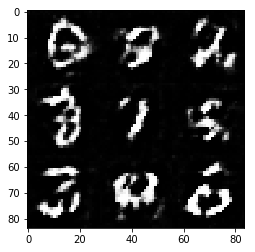

Epoch 1/2... Discriminator Loss: 0.9414... Generator Loss: 1.9800
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 2.1733
Epoch 1/2... Discriminator Loss: 0.9786... Generator Loss: 1.8093
Epoch 1/2... Discriminator Loss: 0.7829... Generator Loss: 1.5659
Epoch 1/2... Discriminator Loss: 1.0658... Generator Loss: 1.1978
Epoch 1/2... Discriminator Loss: 1.3710... Generator Loss: 0.8593
Epoch 1/2... Discriminator Loss: 0.9641... Generator Loss: 1.3150
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 1.3905
Epoch 1/2... Discriminator Loss: 1.0497... Generator Loss: 1.2500
Epoch 1/2... Discriminator Loss: 1.1588... Generator Loss: 1.1820


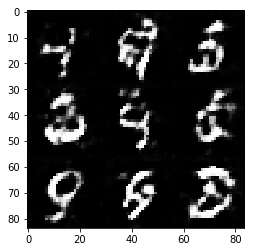

Epoch 1/2... Discriminator Loss: 0.8569... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 1.1144... Generator Loss: 1.1673
Epoch 1/2... Discriminator Loss: 1.2263... Generator Loss: 1.0371
Epoch 1/2... Discriminator Loss: 1.1822... Generator Loss: 1.8586
Epoch 1/2... Discriminator Loss: 1.3089... Generator Loss: 0.7574
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.2260
Epoch 1/2... Discriminator Loss: 1.1141... Generator Loss: 1.5495
Epoch 1/2... Discriminator Loss: 0.9892... Generator Loss: 1.4512
Epoch 1/2... Discriminator Loss: 1.0867... Generator Loss: 2.2834
Epoch 1/2... Discriminator Loss: 1.0476... Generator Loss: 1.6252


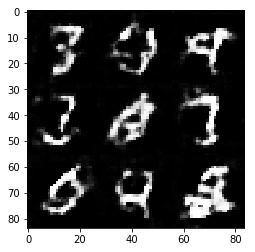

Epoch 1/2... Discriminator Loss: 1.1289... Generator Loss: 1.8116
Epoch 1/2... Discriminator Loss: 1.1262... Generator Loss: 2.3097
Epoch 1/2... Discriminator Loss: 1.0882... Generator Loss: 1.5274
Epoch 1/2... Discriminator Loss: 1.2081... Generator Loss: 1.9615
Epoch 1/2... Discriminator Loss: 1.0119... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 0.9632... Generator Loss: 1.8260
Epoch 1/2... Discriminator Loss: 1.1229... Generator Loss: 1.8561
Epoch 1/2... Discriminator Loss: 1.0807... Generator Loss: 2.2964
Epoch 1/2... Discriminator Loss: 1.1675... Generator Loss: 1.9876
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 1.5840


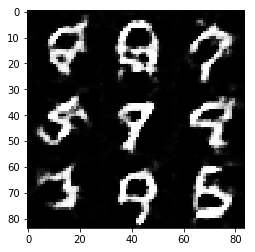

Epoch 1/2... Discriminator Loss: 1.1078... Generator Loss: 1.7359
Epoch 1/2... Discriminator Loss: 1.2785... Generator Loss: 2.0172
Epoch 1/2... Discriminator Loss: 1.1578... Generator Loss: 1.5295
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 1.0398
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 1.1669
Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 1.6856
Epoch 1/2... Discriminator Loss: 1.3055... Generator Loss: 0.9310
Epoch 1/2... Discriminator Loss: 1.0734... Generator Loss: 1.2273
Epoch 1/2... Discriminator Loss: 1.1169... Generator Loss: 1.6772
Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 1.5195


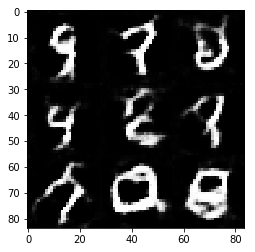

Epoch 1/2... Discriminator Loss: 1.1666... Generator Loss: 1.4256
Epoch 1/2... Discriminator Loss: 1.1307... Generator Loss: 1.2200
Epoch 1/2... Discriminator Loss: 1.2840... Generator Loss: 1.0014
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 1.3834
Epoch 1/2... Discriminator Loss: 1.2106... Generator Loss: 1.2546
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 2.2268
Epoch 1/2... Discriminator Loss: 0.9711... Generator Loss: 1.3739
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 1.3845
Epoch 1/2... Discriminator Loss: 1.0294... Generator Loss: 1.4954
Epoch 1/2... Discriminator Loss: 1.1109... Generator Loss: 1.9058


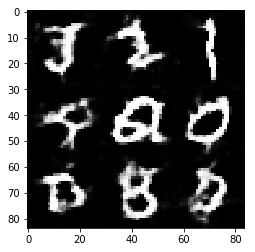

Epoch 1/2... Discriminator Loss: 0.8236... Generator Loss: 1.4602
Epoch 1/2... Discriminator Loss: 1.1994... Generator Loss: 1.3813
Epoch 1/2... Discriminator Loss: 1.0396... Generator Loss: 1.4242
Epoch 1/2... Discriminator Loss: 1.1177... Generator Loss: 1.2214
Epoch 1/2... Discriminator Loss: 1.2211... Generator Loss: 1.3195
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 1.1661
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.6049
Epoch 1/2... Discriminator Loss: 1.1993... Generator Loss: 2.0417
Epoch 1/2... Discriminator Loss: 1.2471... Generator Loss: 1.0874
Epoch 1/2... Discriminator Loss: 1.2442... Generator Loss: 0.9556


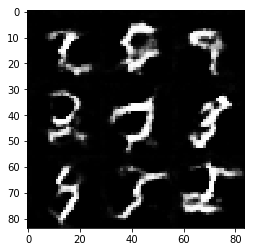

Epoch 1/2... Discriminator Loss: 1.2004... Generator Loss: 0.9933
Epoch 1/2... Discriminator Loss: 1.0464... Generator Loss: 0.8932
Epoch 1/2... Discriminator Loss: 1.1785... Generator Loss: 1.1251
Epoch 1/2... Discriminator Loss: 1.0644... Generator Loss: 1.3142
Epoch 1/2... Discriminator Loss: 1.1707... Generator Loss: 0.9083
Epoch 1/2... Discriminator Loss: 0.8564... Generator Loss: 1.5493
Epoch 1/2... Discriminator Loss: 1.0753... Generator Loss: 1.3784
Epoch 1/2... Discriminator Loss: 1.0607... Generator Loss: 1.1003
Epoch 1/2... Discriminator Loss: 1.3734... Generator Loss: 1.0661
Epoch 1/2... Discriminator Loss: 1.1153... Generator Loss: 1.5031


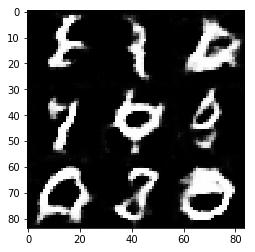

Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.9327
Epoch 2/2... Discriminator Loss: 1.1356... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 1.3139... Generator Loss: 1.3526
Epoch 2/2... Discriminator Loss: 1.3220... Generator Loss: 1.2219
Epoch 2/2... Discriminator Loss: 1.0802... Generator Loss: 1.5133
Epoch 2/2... Discriminator Loss: 1.1466... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 1.0887... Generator Loss: 1.6572
Epoch 2/2... Discriminator Loss: 1.0351... Generator Loss: 1.1183
Epoch 2/2... Discriminator Loss: 1.1032... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.1704... Generator Loss: 0.9642


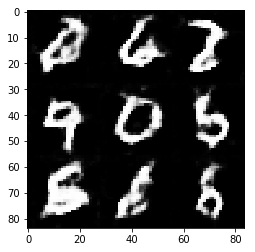

Epoch 2/2... Discriminator Loss: 1.0031... Generator Loss: 1.3333
Epoch 2/2... Discriminator Loss: 0.9720... Generator Loss: 1.2023
Epoch 2/2... Discriminator Loss: 1.0696... Generator Loss: 1.3029
Epoch 2/2... Discriminator Loss: 0.9918... Generator Loss: 1.3267
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.8268
Epoch 2/2... Discriminator Loss: 1.0230... Generator Loss: 1.0699
Epoch 2/2... Discriminator Loss: 1.0292... Generator Loss: 1.3794
Epoch 2/2... Discriminator Loss: 1.2147... Generator Loss: 0.7931
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.9714
Epoch 2/2... Discriminator Loss: 1.1050... Generator Loss: 1.0716


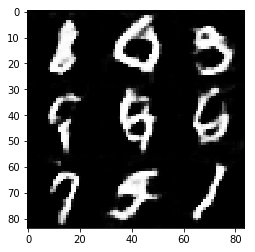

Epoch 2/2... Discriminator Loss: 1.0221... Generator Loss: 1.2437
Epoch 2/2... Discriminator Loss: 1.2527... Generator Loss: 1.1393
Epoch 2/2... Discriminator Loss: 1.1556... Generator Loss: 1.5669
Epoch 2/2... Discriminator Loss: 1.2315... Generator Loss: 1.3531
Epoch 2/2... Discriminator Loss: 1.0289... Generator Loss: 1.3559
Epoch 2/2... Discriminator Loss: 1.2678... Generator Loss: 0.8286
Epoch 2/2... Discriminator Loss: 1.0400... Generator Loss: 1.3284
Epoch 2/2... Discriminator Loss: 1.0794... Generator Loss: 1.2514
Epoch 2/2... Discriminator Loss: 1.1797... Generator Loss: 1.1563
Epoch 2/2... Discriminator Loss: 1.2125... Generator Loss: 0.7854


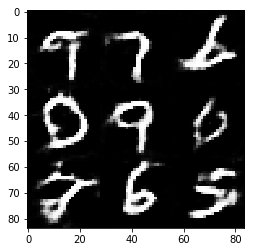

Epoch 2/2... Discriminator Loss: 1.2156... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 1.0357... Generator Loss: 1.4355
Epoch 2/2... Discriminator Loss: 1.0855... Generator Loss: 1.2679
Epoch 2/2... Discriminator Loss: 1.1352... Generator Loss: 1.6509
Epoch 2/2... Discriminator Loss: 1.1678... Generator Loss: 0.8320
Epoch 2/2... Discriminator Loss: 1.1009... Generator Loss: 1.0456
Epoch 2/2... Discriminator Loss: 1.0737... Generator Loss: 1.6414
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 1.3521
Epoch 2/2... Discriminator Loss: 1.1025... Generator Loss: 1.6160
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.3027


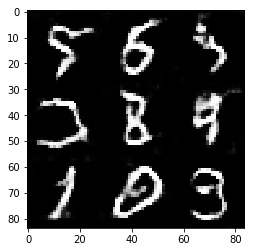

Epoch 2/2... Discriminator Loss: 1.1305... Generator Loss: 1.2029
Epoch 2/2... Discriminator Loss: 1.1669... Generator Loss: 1.4439
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.9974... Generator Loss: 1.5153
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 1.0531
Epoch 2/2... Discriminator Loss: 1.0892... Generator Loss: 1.0942
Epoch 2/2... Discriminator Loss: 1.1150... Generator Loss: 0.9470
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 1.3863
Epoch 2/2... Discriminator Loss: 1.1417... Generator Loss: 0.8820
Epoch 2/2... Discriminator Loss: 1.0671... Generator Loss: 1.3270


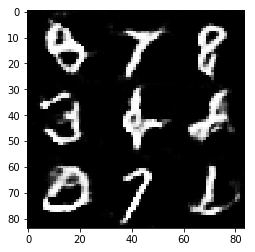

Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 1.0539
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 1.0909... Generator Loss: 1.2255
Epoch 2/2... Discriminator Loss: 1.0402... Generator Loss: 1.5368
Epoch 2/2... Discriminator Loss: 1.2336... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 1.1101... Generator Loss: 1.1163
Epoch 2/2... Discriminator Loss: 1.1237... Generator Loss: 1.6584
Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 1.0163
Epoch 2/2... Discriminator Loss: 1.0220... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 1.1004... Generator Loss: 0.9447


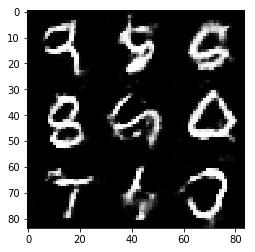

Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 1.4174
Epoch 2/2... Discriminator Loss: 1.1637... Generator Loss: 0.9495
Epoch 2/2... Discriminator Loss: 1.2180... Generator Loss: 0.9801
Epoch 2/2... Discriminator Loss: 1.2012... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 1.2808... Generator Loss: 1.0667
Epoch 2/2... Discriminator Loss: 1.2025... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 1.1767... Generator Loss: 1.3111
Epoch 2/2... Discriminator Loss: 1.1984... Generator Loss: 1.1336
Epoch 2/2... Discriminator Loss: 1.0242... Generator Loss: 1.7167
Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.6215


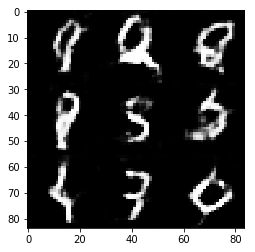

Epoch 2/2... Discriminator Loss: 1.0858... Generator Loss: 1.6683
Epoch 2/2... Discriminator Loss: 0.9496... Generator Loss: 1.4526
Epoch 2/2... Discriminator Loss: 1.0396... Generator Loss: 1.3723
Epoch 2/2... Discriminator Loss: 1.0022... Generator Loss: 1.2541
Epoch 2/2... Discriminator Loss: 0.9733... Generator Loss: 1.1180
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 1.1799
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 1.0467... Generator Loss: 0.9927
Epoch 2/2... Discriminator Loss: 1.1690... Generator Loss: 1.4037
Epoch 2/2... Discriminator Loss: 1.1250... Generator Loss: 1.2827


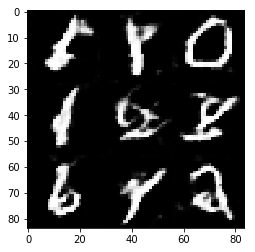

Epoch 2/2... Discriminator Loss: 1.0042... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 1.1642... Generator Loss: 0.8791
Epoch 2/2... Discriminator Loss: 1.1720... Generator Loss: 1.0662
Epoch 2/2... Discriminator Loss: 1.0873... Generator Loss: 1.2256
Epoch 2/2... Discriminator Loss: 0.9877... Generator Loss: 1.2428
Epoch 2/2... Discriminator Loss: 0.9880... Generator Loss: 2.0255
Epoch 2/2... Discriminator Loss: 1.0389... Generator Loss: 1.3956
Epoch 2/2... Discriminator Loss: 1.0551... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 0.9831... Generator Loss: 1.1388
Epoch 2/2... Discriminator Loss: 0.9535... Generator Loss: 1.2099


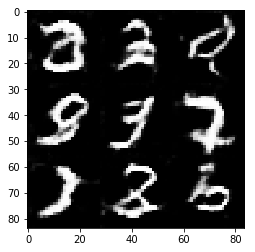

Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 1.8623
Epoch 2/2... Discriminator Loss: 1.0690... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 1.1197... Generator Loss: 0.9965
Epoch 2/2... Discriminator Loss: 1.1215... Generator Loss: 1.3448
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 1.5084
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.3126
Epoch 2/2... Discriminator Loss: 1.0960... Generator Loss: 1.1786
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.1570
Epoch 2/2... Discriminator Loss: 0.9940... Generator Loss: 1.5401


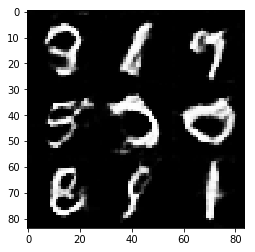

Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 1.8371
Epoch 2/2... Discriminator Loss: 0.8125... Generator Loss: 1.5149
Epoch 2/2... Discriminator Loss: 0.9902... Generator Loss: 1.3799
Epoch 2/2... Discriminator Loss: 0.9995... Generator Loss: 1.8721
Epoch 2/2... Discriminator Loss: 1.0447... Generator Loss: 1.1067
Epoch 2/2... Discriminator Loss: 1.0465... Generator Loss: 1.4571
Epoch 2/2... Discriminator Loss: 0.9560... Generator Loss: 0.9957
Epoch 2/2... Discriminator Loss: 1.0296... Generator Loss: 1.5817
Epoch 2/2... Discriminator Loss: 1.0346... Generator Loss: 1.1033
Epoch 2/2... Discriminator Loss: 1.1261... Generator Loss: 1.1921


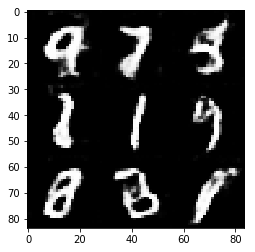

Epoch 2/2... Discriminator Loss: 1.0622... Generator Loss: 1.2852
Epoch 2/2... Discriminator Loss: 1.0335... Generator Loss: 1.4473
Epoch 2/2... Discriminator Loss: 1.0198... Generator Loss: 1.6384
Epoch 2/2... Discriminator Loss: 0.9836... Generator Loss: 1.1440
Epoch 2/2... Discriminator Loss: 1.1347... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.0418... Generator Loss: 1.5242
Epoch 2/2... Discriminator Loss: 0.8552... Generator Loss: 1.3779
Epoch 2/2... Discriminator Loss: 1.0260... Generator Loss: 1.3310
Epoch 2/2... Discriminator Loss: 0.9829... Generator Loss: 0.9964
Epoch 2/2... Discriminator Loss: 0.9709... Generator Loss: 2.0576


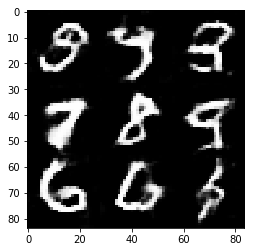

IndexError: list index out of range

In [12]:
batch_size = 50
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6141... Generator Loss: 2.5497
Epoch 1/1... Discriminator Loss: 0.5229... Generator Loss: 3.3957
Epoch 1/1... Discriminator Loss: 0.5315... Generator Loss: 3.6354
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 3.7463
Epoch 1/1... Discriminator Loss: 0.4531... Generator Loss: 3.9287
Epoch 1/1... Discriminator Loss: 0.7223... Generator Loss: 4.9168
Epoch 1/1... Discriminator Loss: 0.6436... Generator Loss: 3.1760
Epoch 1/1... Discriminator Loss: 1.9371... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 0.9881... Generator Loss: 1.0571
Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 1.0128


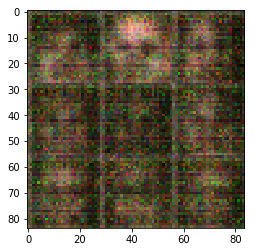

Epoch 1/1... Discriminator Loss: 1.0958... Generator Loss: 1.2679
Epoch 1/1... Discriminator Loss: 0.9664... Generator Loss: 1.3829
Epoch 1/1... Discriminator Loss: 0.9040... Generator Loss: 1.3227
Epoch 1/1... Discriminator Loss: 0.8026... Generator Loss: 2.1615
Epoch 1/1... Discriminator Loss: 0.7024... Generator Loss: 3.3851
Epoch 1/1... Discriminator Loss: 0.6872... Generator Loss: 3.7074
Epoch 1/1... Discriminator Loss: 0.5774... Generator Loss: 2.8232
Epoch 1/1... Discriminator Loss: 0.6057... Generator Loss: 2.8066
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 1.4919
Epoch 1/1... Discriminator Loss: 0.8583... Generator Loss: 1.8906


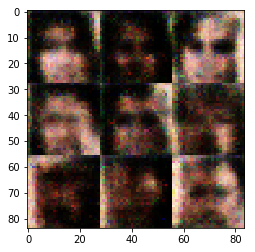

Epoch 1/1... Discriminator Loss: 0.8706... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 0.7001... Generator Loss: 2.2034
Epoch 1/1... Discriminator Loss: 0.8801... Generator Loss: 2.5660
Epoch 1/1... Discriminator Loss: 0.6000... Generator Loss: 2.2552
Epoch 1/1... Discriminator Loss: 0.6472... Generator Loss: 3.1163
Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 2.8990
Epoch 1/1... Discriminator Loss: 0.8048... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.7124
Epoch 1/1... Discriminator Loss: 0.8136... Generator Loss: 1.6064
Epoch 1/1... Discriminator Loss: 1.0289... Generator Loss: 1.0877


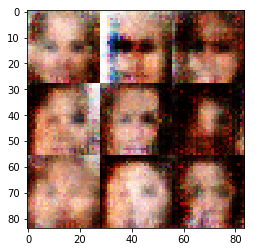

Epoch 1/1... Discriminator Loss: 0.7067... Generator Loss: 2.2069
Epoch 1/1... Discriminator Loss: 0.8656... Generator Loss: 2.4118
Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 1.8879
Epoch 1/1... Discriminator Loss: 0.7781... Generator Loss: 2.7766
Epoch 1/1... Discriminator Loss: 0.7610... Generator Loss: 2.0672
Epoch 1/1... Discriminator Loss: 0.6901... Generator Loss: 2.1229
Epoch 1/1... Discriminator Loss: 0.8478... Generator Loss: 1.5338
Epoch 1/1... Discriminator Loss: 0.7539... Generator Loss: 2.7222
Epoch 1/1... Discriminator Loss: 0.8365... Generator Loss: 1.5977
Epoch 1/1... Discriminator Loss: 0.7099... Generator Loss: 2.1957


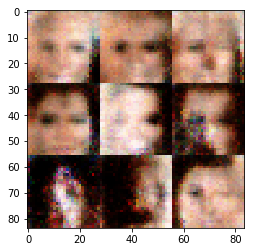

Epoch 1/1... Discriminator Loss: 0.6784... Generator Loss: 2.3815
Epoch 1/1... Discriminator Loss: 0.7248... Generator Loss: 1.6850
Epoch 1/1... Discriminator Loss: 0.8582... Generator Loss: 1.6274
Epoch 1/1... Discriminator Loss: 0.8664... Generator Loss: 2.6903
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.5273
Epoch 1/1... Discriminator Loss: 0.8068... Generator Loss: 2.2233
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8830
Epoch 1/1... Discriminator Loss: 0.8080... Generator Loss: 2.3157
Epoch 1/1... Discriminator Loss: 0.8573... Generator Loss: 1.7039
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 3.0232


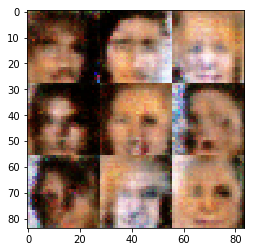

Epoch 1/1... Discriminator Loss: 1.1442... Generator Loss: 3.4357
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 2.3253
Epoch 1/1... Discriminator Loss: 0.7893... Generator Loss: 1.8028
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 2.1109
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 2.6255
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 3.0610
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.2442
Epoch 1/1... Discriminator Loss: 0.8855... Generator Loss: 1.3132
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.9491
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 1.9172


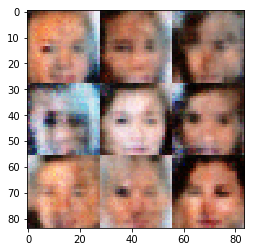

Epoch 1/1... Discriminator Loss: 0.8716... Generator Loss: 2.5469
Epoch 1/1... Discriminator Loss: 0.9717... Generator Loss: 1.4439
Epoch 1/1... Discriminator Loss: 1.0614... Generator Loss: 3.1175
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 1.2437
Epoch 1/1... Discriminator Loss: 0.9964... Generator Loss: 1.5740
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.4727
Epoch 1/1... Discriminator Loss: 0.9008... Generator Loss: 1.9846
Epoch 1/1... Discriminator Loss: 1.0194... Generator Loss: 1.9210
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 0.9652
Epoch 1/1... Discriminator Loss: 0.9561... Generator Loss: 1.8595


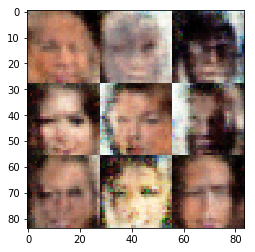

Epoch 1/1... Discriminator Loss: 0.8876... Generator Loss: 2.1661
Epoch 1/1... Discriminator Loss: 0.9021... Generator Loss: 2.0192
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 2.6033
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.7438
Epoch 1/1... Discriminator Loss: 1.0159... Generator Loss: 1.1539
Epoch 1/1... Discriminator Loss: 0.9753... Generator Loss: 1.7137
Epoch 1/1... Discriminator Loss: 1.0389... Generator Loss: 1.3333
Epoch 1/1... Discriminator Loss: 0.9328... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 1.1984... Generator Loss: 1.0795


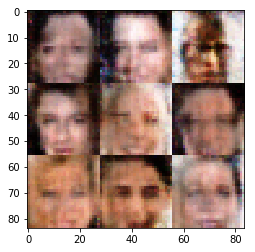

Epoch 1/1... Discriminator Loss: 0.9714... Generator Loss: 1.6595
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 1.0733... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 1.1313... Generator Loss: 0.8948
Epoch 1/1... Discriminator Loss: 1.2228... Generator Loss: 1.6687
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 2.4152
Epoch 1/1... Discriminator Loss: 1.0603... Generator Loss: 1.7767
Epoch 1/1... Discriminator Loss: 0.8452... Generator Loss: 2.2506
Epoch 1/1... Discriminator Loss: 1.0257... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 1.0738... Generator Loss: 0.8297


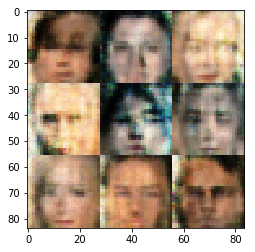

Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 2.2269
Epoch 1/1... Discriminator Loss: 0.9209... Generator Loss: 1.6922
Epoch 1/1... Discriminator Loss: 1.0500... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.0671
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 2.1613
Epoch 1/1... Discriminator Loss: 1.3720... Generator Loss: 1.9288
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 2.2338
Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.8427
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 1.5350


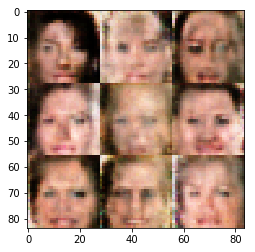

Epoch 1/1... Discriminator Loss: 0.9249... Generator Loss: 1.3639
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.2393
Epoch 1/1... Discriminator Loss: 1.0682... Generator Loss: 1.2029
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 1.1615
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 1.4787
Epoch 1/1... Discriminator Loss: 1.1539... Generator Loss: 1.5269
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 2.0997
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.0981... Generator Loss: 1.3277


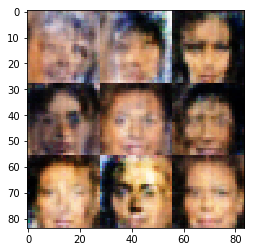

Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.2447
Epoch 1/1... Discriminator Loss: 1.2761... Generator Loss: 2.3899
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.5757
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 1.0885
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 1.1928
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0141
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.4714
Epoch 1/1... Discriminator Loss: 0.8278... Generator Loss: 1.5011
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.8829
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.9774


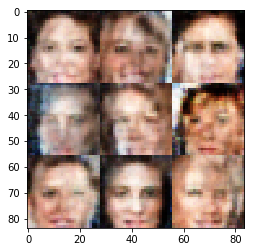

Epoch 1/1... Discriminator Loss: 1.0160... Generator Loss: 1.5073
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.4748
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.9697
Epoch 1/1... Discriminator Loss: 0.7406... Generator Loss: 2.1084
Epoch 1/1... Discriminator Loss: 1.0715... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 1.4891... Generator Loss: 0.6290
Epoch 1/1... Discriminator Loss: 0.8554... Generator Loss: 1.4696
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.2547
Epoch 1/1... Discriminator Loss: 1.0743... Generator Loss: 1.3540


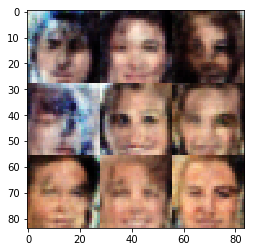

Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.4698
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.3073
Epoch 1/1... Discriminator Loss: 0.9791... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 0.8285... Generator Loss: 1.4262
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.4507
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.1832
Epoch 1/1... Discriminator Loss: 1.0695... Generator Loss: 1.7077
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 1.2394
Epoch 1/1... Discriminator Loss: 1.0521... Generator Loss: 1.0836


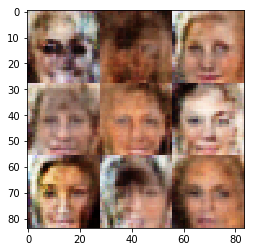

Epoch 1/1... Discriminator Loss: 0.9747... Generator Loss: 1.6578
Epoch 1/1... Discriminator Loss: 0.8998... Generator Loss: 1.4607
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 1.0555
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.7917
Epoch 1/1... Discriminator Loss: 0.9513... Generator Loss: 1.2867
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8999
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 1.9539
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 1.5213
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 1.3482
Epoch 1/1... Discriminator Loss: 1.2661... Generator Loss: 1.2102


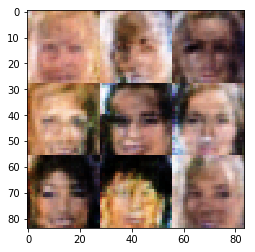

Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 1.0055
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 2.0362
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.1395
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 1.1891
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 1.1331
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 1.3553
Epoch 1/1... Discriminator Loss: 1.1332... Generator Loss: 1.0190
Epoch 1/1... Discriminator Loss: 1.0877... Generator Loss: 1.6313
Epoch 1/1... Discriminator Loss: 1.0349... Generator Loss: 1.1607


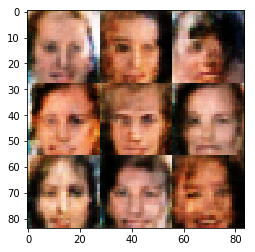

Epoch 1/1... Discriminator Loss: 1.0465... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.2436... Generator Loss: 1.1950
Epoch 1/1... Discriminator Loss: 1.1116... Generator Loss: 1.1857
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 1.6691
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.9066
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 1.2362
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.1142
Epoch 1/1... Discriminator Loss: 1.0766... Generator Loss: 1.9409
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 1.1370


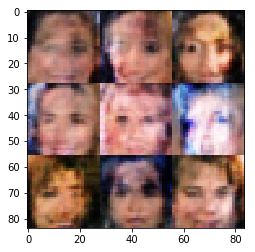

Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.2572
Epoch 1/1... Discriminator Loss: 1.2351... Generator Loss: 1.2883
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.2134... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.1062... Generator Loss: 1.1632
Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 1.6216
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 1.4726
Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.2015
Epoch 1/1... Discriminator Loss: 1.1385... Generator Loss: 1.6163


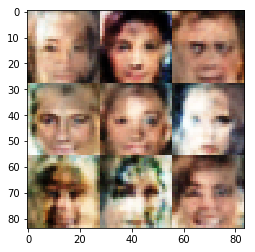

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.7157
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 1.2784
Epoch 1/1... Discriminator Loss: 1.0018... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 0.9991... Generator Loss: 1.3494
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 0.9760... Generator Loss: 1.3855
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.1729
Epoch 1/1... Discriminator Loss: 1.0578... Generator Loss: 1.2282
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2865... Generator Loss: 1.4393


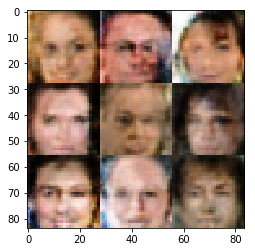

Epoch 1/1... Discriminator Loss: 0.8654... Generator Loss: 1.5498
Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 1.0241
Epoch 1/1... Discriminator Loss: 1.0703... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 1.7578
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.9046
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 1.7136
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.2850
Epoch 1/1... Discriminator Loss: 1.1205... Generator Loss: 1.3526
Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 1.2842


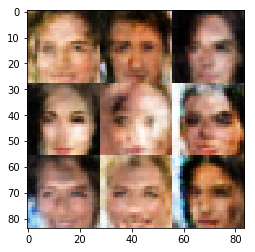

Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 1.0444... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 1.3797
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 1.0374
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 1.0758
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 1.2131
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.2928
Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 1.1933
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.2620


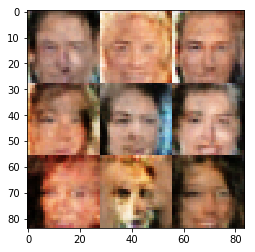

Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.0137
Epoch 1/1... Discriminator Loss: 0.9930... Generator Loss: 1.3587
Epoch 1/1... Discriminator Loss: 0.9159... Generator Loss: 1.3519
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.0803... Generator Loss: 1.2306
Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9701
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.1883
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.2048
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 1.5507


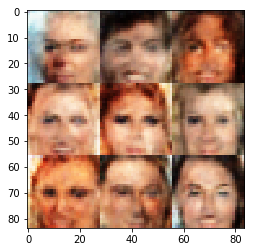

Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 1.1010... Generator Loss: 1.0676
Epoch 1/1... Discriminator Loss: 1.1086... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.2964
Epoch 1/1... Discriminator Loss: 1.1948... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.1961
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 1.2556
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9248
Epoch 1/1... Discriminator Loss: 0.9869... Generator Loss: 1.6047


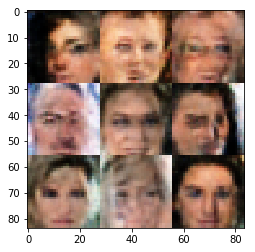

Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.0849... Generator Loss: 1.0586
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 1.2403
Epoch 1/1... Discriminator Loss: 1.4532... Generator Loss: 1.1980
Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.9557
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 1.1861
Epoch 1/1... Discriminator Loss: 0.9910... Generator Loss: 1.1548
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.9318


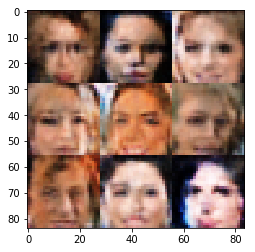

Epoch 1/1... Discriminator Loss: 1.2191... Generator Loss: 1.3906
Epoch 1/1... Discriminator Loss: 1.1085... Generator Loss: 1.1242
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 1.3153
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 1.2465
Epoch 1/1... Discriminator Loss: 1.1444... Generator Loss: 0.9264
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 1.7223
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9209
Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 1.2374
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 1.2429


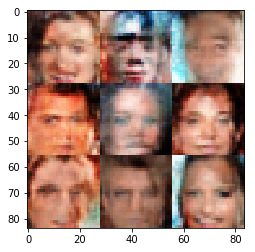

Epoch 1/1... Discriminator Loss: 0.9469... Generator Loss: 1.2921
Epoch 1/1... Discriminator Loss: 1.0809... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.3827
Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 1.0774
Epoch 1/1... Discriminator Loss: 1.1259... Generator Loss: 1.0992
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 1.0189
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.9886
Epoch 1/1... Discriminator Loss: 1.1460... Generator Loss: 1.0615


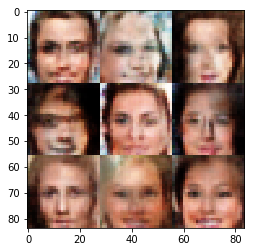

Epoch 1/1... Discriminator Loss: 1.2146... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 1.1422
Epoch 1/1... Discriminator Loss: 1.1345... Generator Loss: 1.2748
Epoch 1/1... Discriminator Loss: 1.0496... Generator Loss: 1.2711
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 0.9969... Generator Loss: 1.0409
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.0562... Generator Loss: 1.0989
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 1.1675


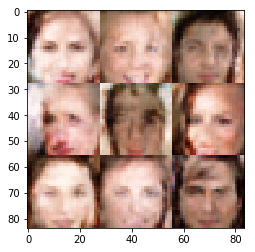

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 0.8781... Generator Loss: 1.5517
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 1.5409
Epoch 1/1... Discriminator Loss: 1.0728... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 1.1427
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 1.1371
Epoch 1/1... Discriminator Loss: 1.0723... Generator Loss: 1.1979
Epoch 1/1... Discriminator Loss: 1.3336... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 1.0336


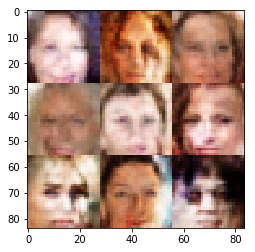

Epoch 1/1... Discriminator Loss: 1.2646... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 1.1016
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 1.2268... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2136
Epoch 1/1... Discriminator Loss: 1.0978... Generator Loss: 2.0984
Epoch 1/1... Discriminator Loss: 1.2562... Generator Loss: 1.4251
Epoch 1/1... Discriminator Loss: 1.3385... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 1.1336


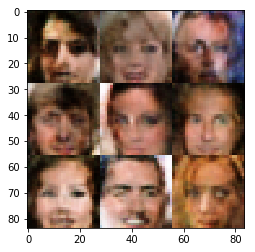

Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 0.9479... Generator Loss: 1.2585
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 0.9491... Generator Loss: 1.5450
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.0050
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.5496
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 1.2770


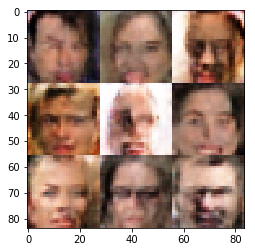

Epoch 1/1... Discriminator Loss: 1.3255... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 1.1326... Generator Loss: 1.3310
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.0438
Epoch 1/1... Discriminator Loss: 1.0879... Generator Loss: 1.3396
Epoch 1/1... Discriminator Loss: 1.0540... Generator Loss: 1.5672
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 1.2762
Epoch 1/1... Discriminator Loss: 1.1579... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.9763... Generator Loss: 1.4462


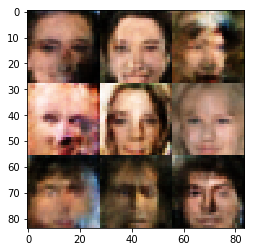

Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8493
Epoch 1/1... Discriminator Loss: 1.1567... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 0.9149... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.3341
Epoch 1/1... Discriminator Loss: 1.1092... Generator Loss: 1.1749
Epoch 1/1... Discriminator Loss: 1.0423... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1275... Generator Loss: 1.0287


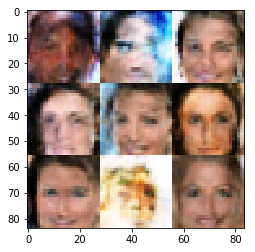

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 1.2000
Epoch 1/1... Discriminator Loss: 0.9835... Generator Loss: 1.4277
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.3054
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.5396... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.0435... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.2034... Generator Loss: 0.9589


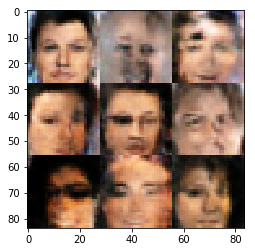

Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 1.5917
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 1.2444
Epoch 1/1... Discriminator Loss: 1.0851... Generator Loss: 1.5066
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 1.3789
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.1803
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7956
Epoch 1/1... Discriminator Loss: 1.1863... Generator Loss: 0.9598
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 1.0487


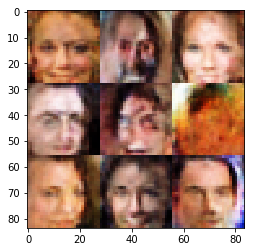

Epoch 1/1... Discriminator Loss: 1.0640... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 0.9656... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.1305
Epoch 1/1... Discriminator Loss: 1.0536... Generator Loss: 1.4021
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 1.3000
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 0.9071... Generator Loss: 1.8452
Epoch 1/1... Discriminator Loss: 1.1463... Generator Loss: 0.9806
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.4411
Epoch 1/1... Discriminator Loss: 1.1049... Generator Loss: 1.1818


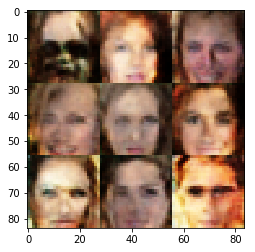

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 1.1574
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 0.9960... Generator Loss: 1.5699
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.4466
Epoch 1/1... Discriminator Loss: 0.9772... Generator Loss: 1.5792
Epoch 1/1... Discriminator Loss: 1.0628... Generator Loss: 1.2869
Epoch 1/1... Discriminator Loss: 1.0343... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.1130... Generator Loss: 1.4940
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.9387... Generator Loss: 1.7365


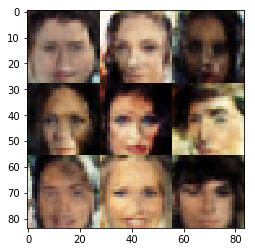

Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 1.1375
Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.8570
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.4967
Epoch 1/1... Discriminator Loss: 0.9485... Generator Loss: 1.2466
Epoch 1/1... Discriminator Loss: 1.0807... Generator Loss: 1.2666
Epoch 1/1... Discriminator Loss: 1.3870... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.0419... Generator Loss: 1.2985
Epoch 1/1... Discriminator Loss: 1.1036... Generator Loss: 0.9099
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.9883


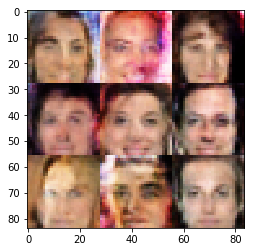

Epoch 1/1... Discriminator Loss: 1.3152... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.0899... Generator Loss: 0.9715
Epoch 1/1... Discriminator Loss: 1.0374... Generator Loss: 1.1244
Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 1.3113
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 1.1207
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 1.1179... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.0038... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1475... Generator Loss: 1.0611
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0147


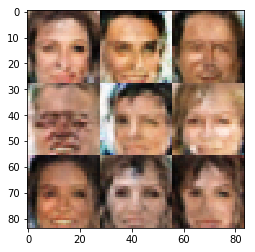

Epoch 1/1... Discriminator Loss: 1.3211... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2157... Generator Loss: 0.8551
Epoch 1/1... Discriminator Loss: 1.1606... Generator Loss: 1.4243
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 1.2435
Epoch 1/1... Discriminator Loss: 1.2029... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.1357
Epoch 1/1... Discriminator Loss: 1.1145... Generator Loss: 1.2006
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.3755
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.9787
Epoch 1/1... Discriminator Loss: 1.1051... Generator Loss: 1.1361


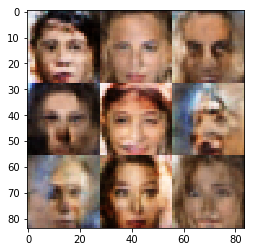

Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.2940
Epoch 1/1... Discriminator Loss: 1.0453... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.1681
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 0.8100
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 1.4736
Epoch 1/1... Discriminator Loss: 0.9995... Generator Loss: 1.4902
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 1.1080


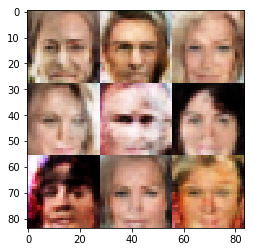

Epoch 1/1... Discriminator Loss: 1.0074... Generator Loss: 1.4248
Epoch 1/1... Discriminator Loss: 1.1035... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.1668... Generator Loss: 1.4835
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2006... Generator Loss: 0.9698


IndexError: list index out of range

In [13]:
batch_size = 50
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.